## Instance segmentation model performance ##

In [17]:
# Imports
import os
import numpy as np
import pandas as pd
import json
import time
import glob
import random
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# PyTorch libraries
import torch

# Detectron2 library
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.fileutils import FileOP

print(f'Project module version: {dm.__version__}')
print(f'Detectron2 version:     {detectron2.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.post1.dev163+g9fa083d.d20240224
Detectron2 version:     0.6


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3070 Laptop GPU
CUDNN version:         8902

Device for model training/inference: cuda:0


In [26]:
# Path settings 
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = os.environ.get('DATA_ROOT')

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')
output_dir_predictions = os.path.join(output_dir, 'segm_predictions')
Path(output_dir_predictions).mkdir(parents=True, exist_ok=True)

# Data frame with data splits 
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

# Annotation file for testdata
test_annotation_file_name = 'dentex_detection_test.json'
test_annotation_file = os.path.join(data_dir, test_annotation_file_name)

### Register the test dataset ####

In [4]:
with open(test_annotation_file, 'r') as fl:
    annotations = json.load(fl)
dataset_name = 'dentex_test'
annotations_dict = {dataset_name: annotations}
if dataset_name not in DatasetCatalog:
    DatasetCatalog.register(name=dataset_name, func=lambda d=dataset_name: annotations_dict.get(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])

### Detectron2 performance testing ###

In [5]:
# Let's see if we have a saved checkpoint. If not, use this one:
link = 'https://dsets.s3.amazonaws.com/dentex/toothsegmentation_1K.pth'

# The previous training notebook should have the defined model name
model_name = 'Toothsegment'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir, 
                              model_name,
                              f'version_{model_version}')

last_checkpoint_name = 'model_final.pth'
last_checkpoint = glob.glob(os.path.join(checkpoint_dir, last_checkpoint_name))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "{last_checkpoint_name}" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "{last_checkpoint_name}" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "model_final.pth" in /app/data/model/Toothsegment/version_1.


In [12]:
output_dir = os.path.join(model_dir, model_name, f'version_{model_version}')

# Load the config file. This was created right before training the model.
model_config_file_name = f'{model_name}_{model_version}_config.yml'
model_config_file = os.path.join(output_dir, model_config_file_name)

# Recreate the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_config_file)
cfg.MODEL.DEVICE = device.type
cfg.MODEL.WEIGHTS = checkpoint_file

# Create the dentex predictor instance
predictor = DefaultPredictor(cfg)
val_loader = build_detection_test_loader(cfg, 'dentex_test')

# Create COCO-Evaluator for the test set
evaluator = COCOEvaluator(dataset_name='dentex_test', 
                          tasks=('bbox', 'segm', ), 
                          distributed=False, 
                          output_dir=output_dir)

# Run model evaluation on test set
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Combine test results on bounding boxes and segmentations into one table
results_df_list = []
for task in ['bbox', 'segm']:
    results_df_task = pd.DataFrame(results.get(task), index=[0]).\
                    assign(checkpoint=os.path.basename(checkpoint_file),
                           task=task)
    results_df_list.append(results_df_task)
results_df = pd.concat(results_df_list, axis=0, ignore_index=True)
print()
display(results_df)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.978
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.521
 Average Recall     (AR) @[ IoU=0.50:

AP       AP50       AP75  APs        APm        APl       checkpoint  task
0  53.848295  97.773610  51.021769  NaN  51.914191  53.990750  model_final.pth  bbox
1  52.008804  97.736272  50.281877  NaN  43.900973  52.099486  model_final.pth  segm

### Example predictions on the test images ###

In [13]:
files = pd.read_parquet(data_df_file)
files = files.loc[files['dataset']=='test'].\
                reset_index(drop=True)
display(files.head())

def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

image_id      file_name  image_number                                          file_path dataset
0       601  train_298.png           298  /app/data/dentex/dentex_detection/quadrant_enu...    test
1       222  train_365.png           365  /app/data/dentex/dentex_detection/quadrant_enu...    test
2       478  train_595.png           595  /app/data/dentex/dentex_detection/quadrant_enu...    test
3       451  train_517.png           517  /app/data/dentex/dentex_detection/quadrant_enu...    test
4       160  train_467.png           467  /app/data/dentex/dentex_detection/quadrant_enu...    test


File 1 of 15: train_298.png with 35 instances.

The detection of the 35 segmentations took 1.098 seconds.



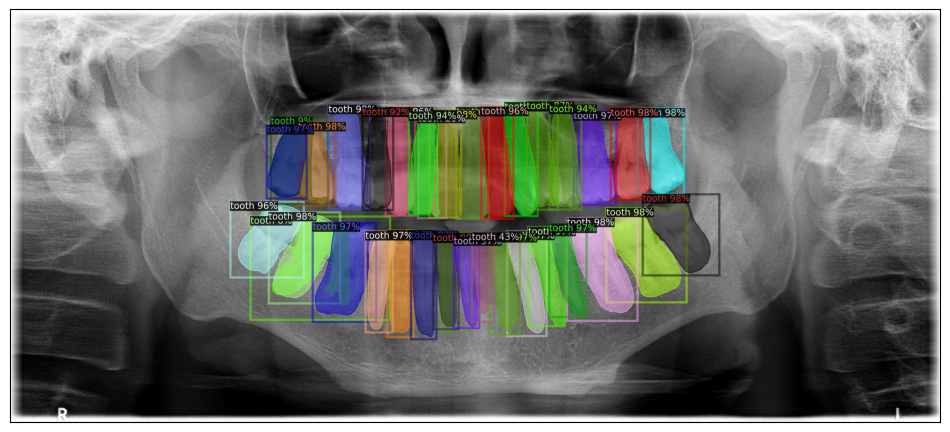


File 2 of 15: train_365.png with 34 instances.

The detection of the 34 segmentations took 1.044 seconds.



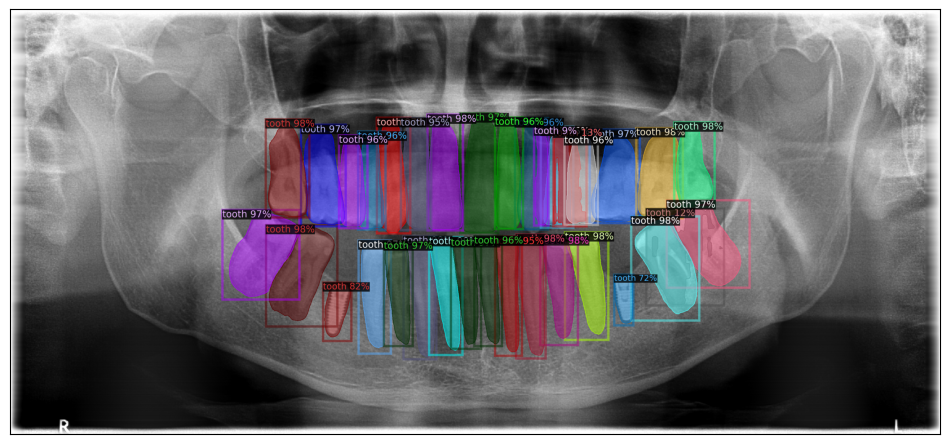


File 3 of 15: train_595.png with 38 instances.

The detection of the 38 segmentations took 1.156 seconds.



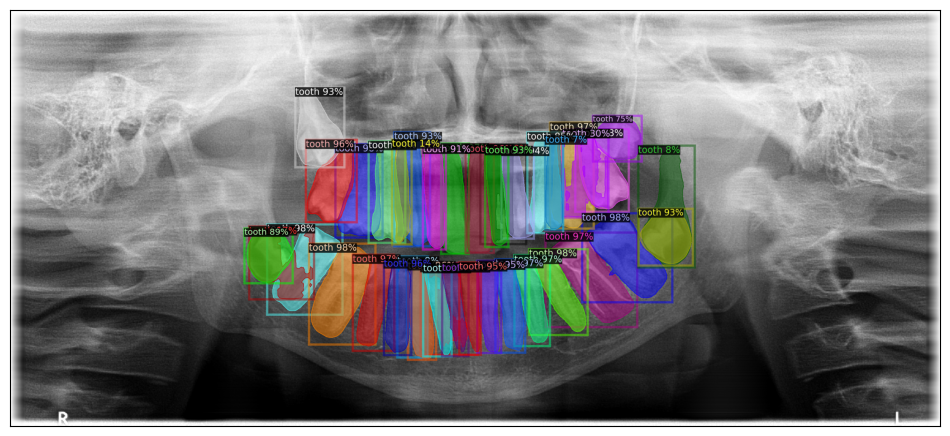


File 4 of 15: train_517.png with 45 instances.

The detection of the 45 segmentations took 1.324 seconds.



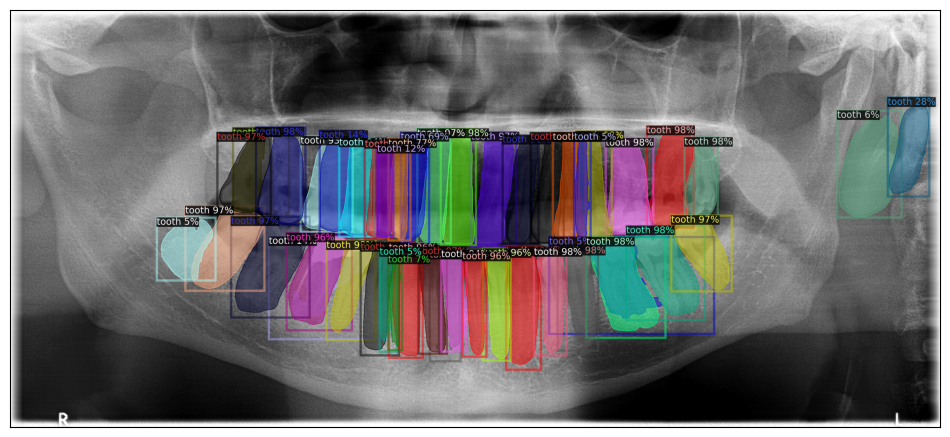


File 5 of 15: train_467.png with 38 instances.

The detection of the 38 segmentations took 1.089 seconds.



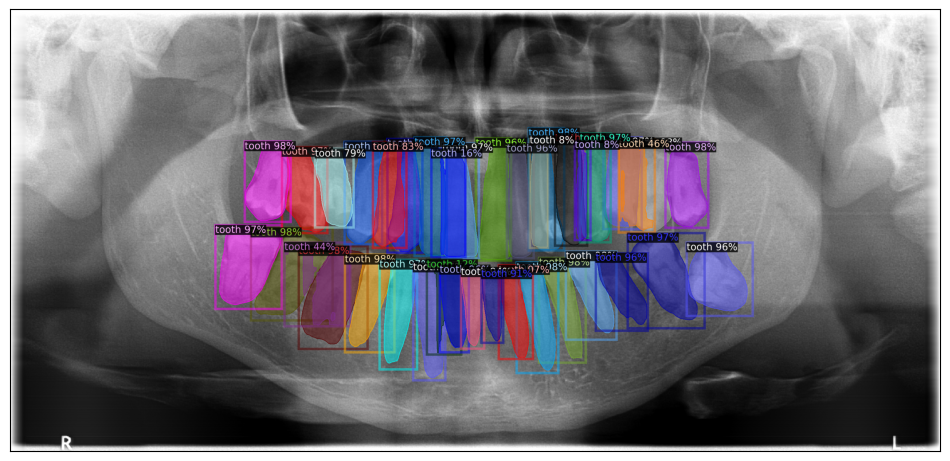


File 6 of 15: train_308.png with 34 instances.

The detection of the 34 segmentations took 1.106 seconds.



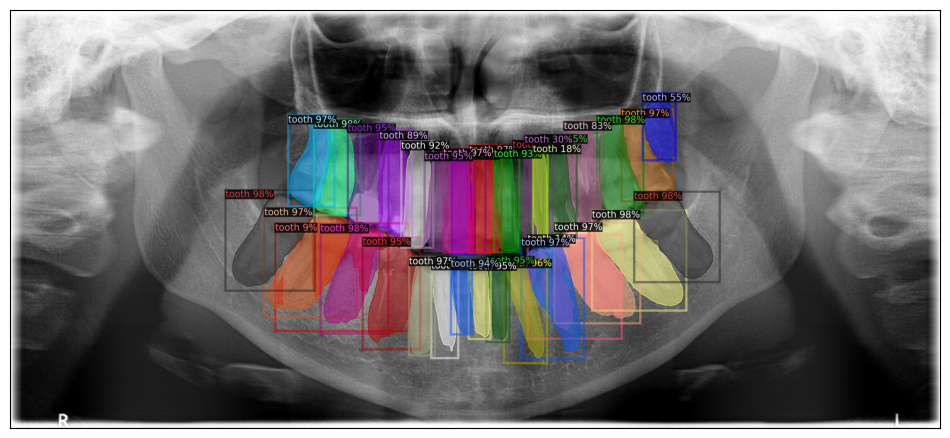


File 7 of 15: train_359.png with 41 instances.

The detection of the 41 segmentations took 1.184 seconds.



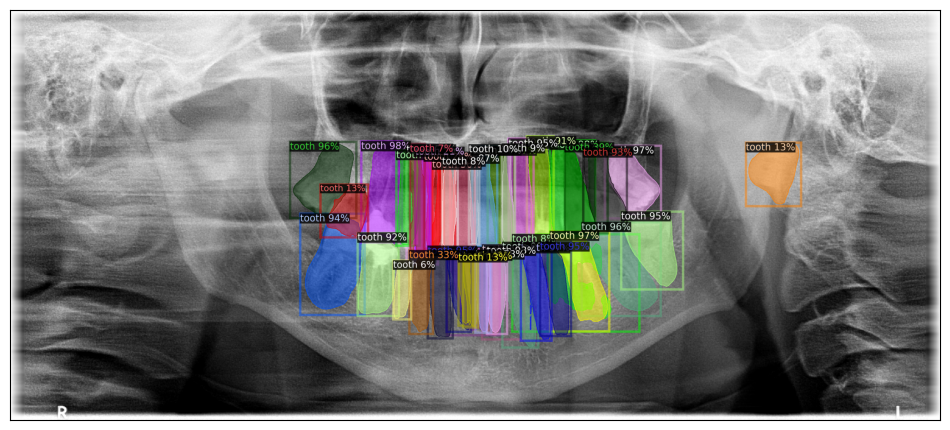


File 8 of 15: train_152.png with 32 instances.

The detection of the 32 segmentations took 1.322 seconds.



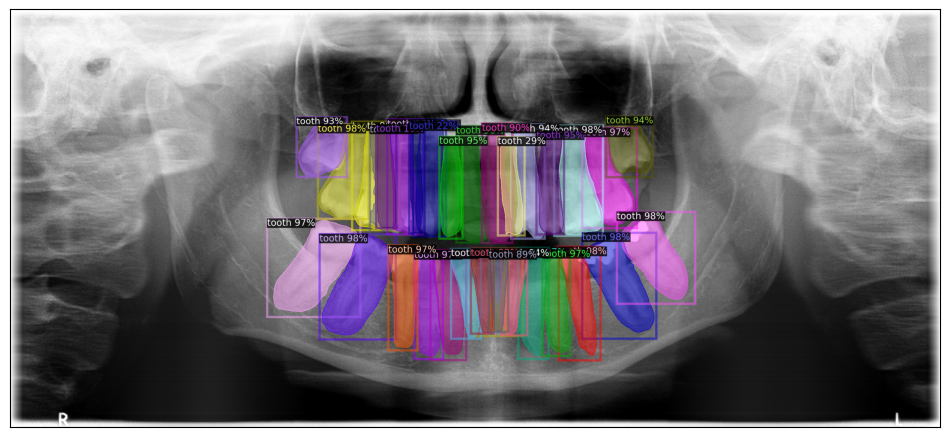


File 9 of 15: train_29.png with 31 instances.

The detection of the 31 segmentations took 0.921 seconds.



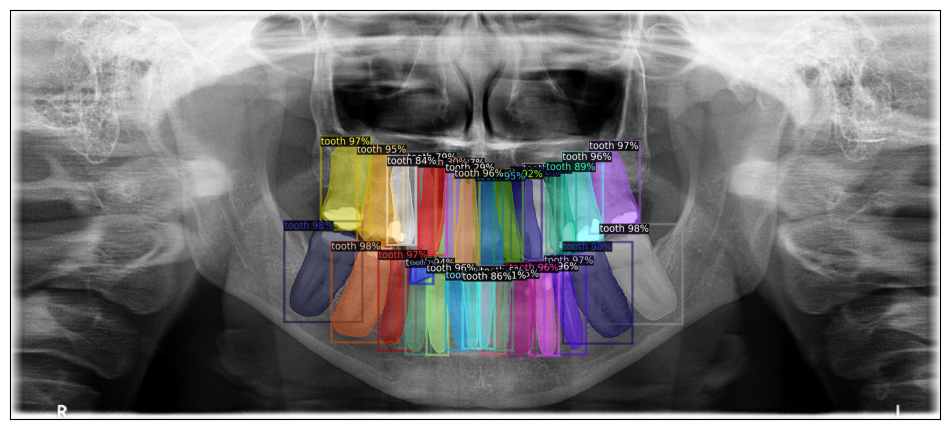


File 10 of 15: train_54.png with 39 instances.

The detection of the 39 segmentations took 1.136 seconds.



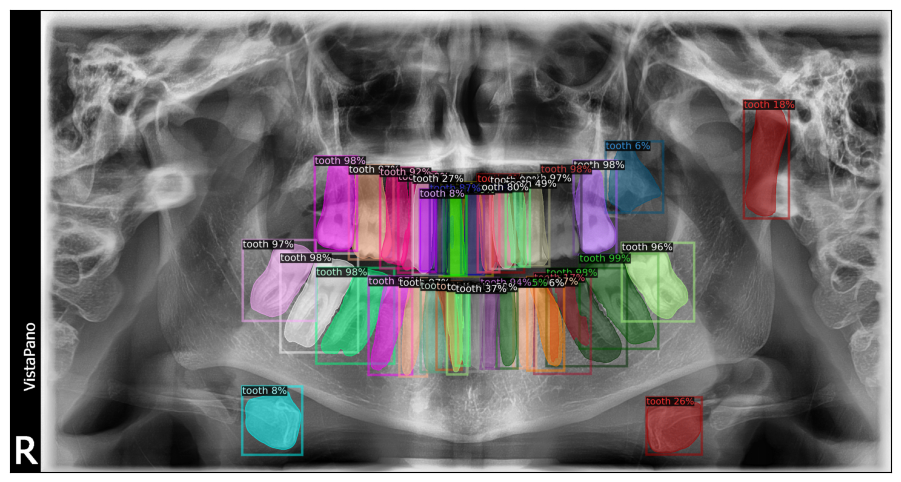


File 11 of 15: train_439.png with 35 instances.

The detection of the 35 segmentations took 1.019 seconds.



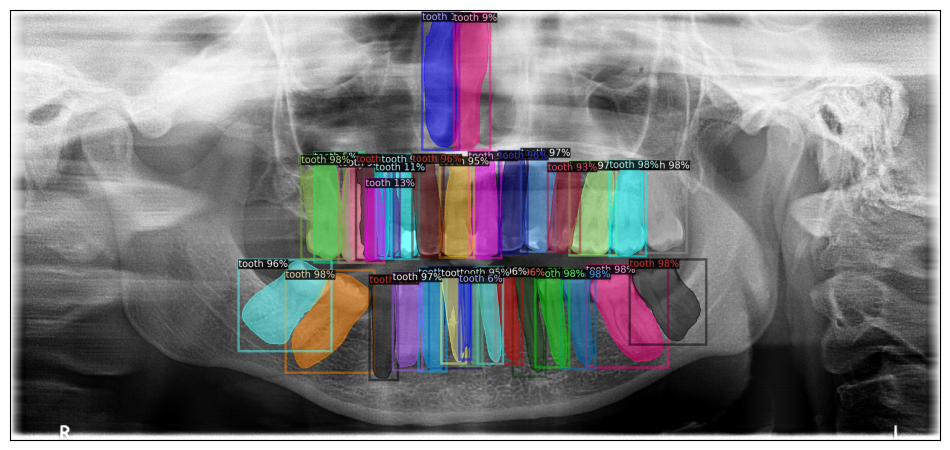


File 12 of 15: train_560.png with 37 instances.

The detection of the 37 segmentations took 1.060 seconds.



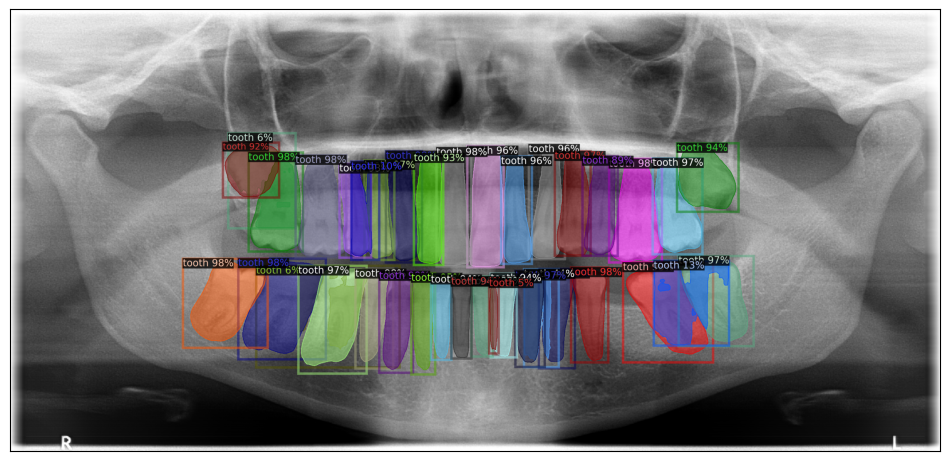


File 13 of 15: train_594.png with 32 instances.

The detection of the 32 segmentations took 1.011 seconds.



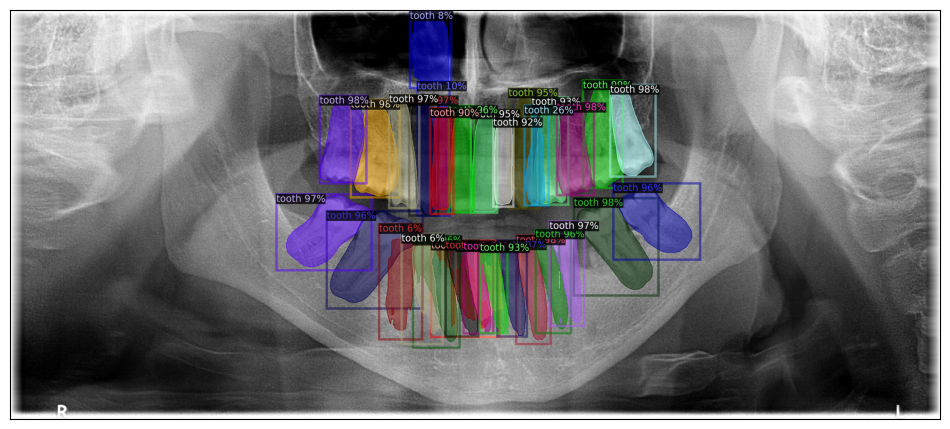


File 14 of 15: train_106.png with 31 instances.

The detection of the 31 segmentations took 0.952 seconds.



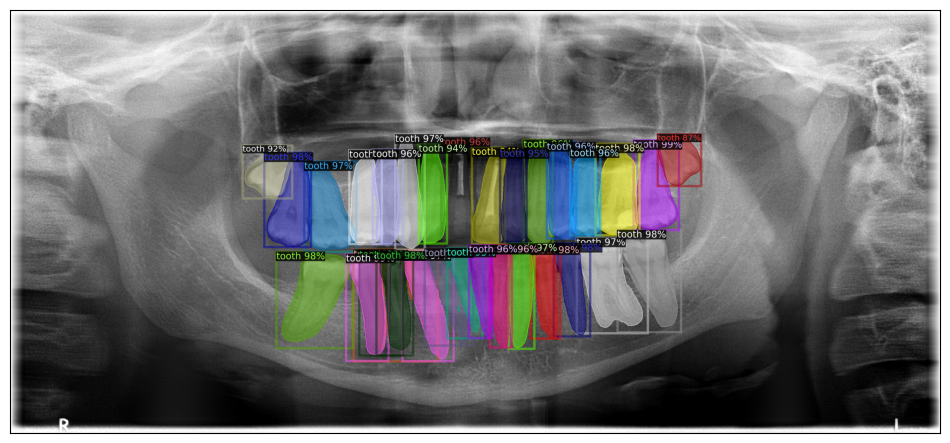


File 15 of 15: train_415.png with 31 instances.

The detection of the 31 segmentations took 0.986 seconds.



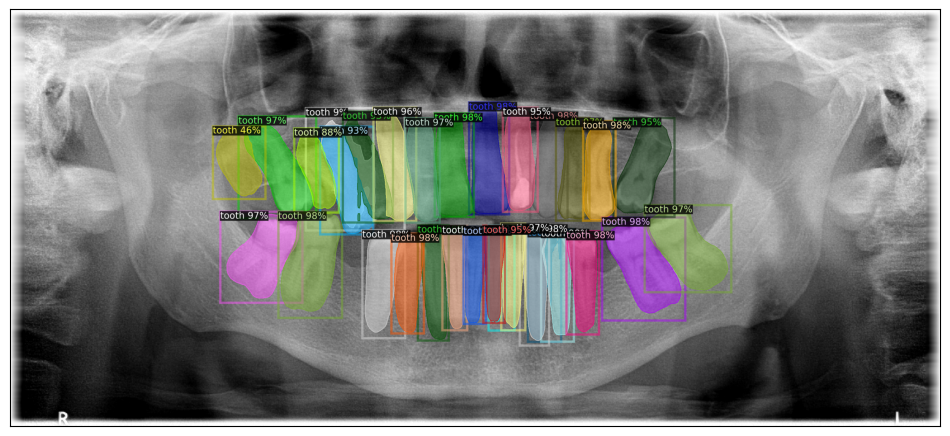

In [45]:
# Load the image
box_df_list = []
n_output_images = 15
image_number_list = files['image_number'].unique()[:n_output_images]

for i, image_number in enumerate(image_number_list):
    start_time = time.time()
    image_df = files.loc[files['image_number'] == image_number]
    image_file = image_df['file_path'].values[0]
    image_name = image_df['file_name'].values[0]
    im = ImageData().load_image(image_file)
    # Instance segmentation predictions for this image
    pred = predictor(im)
    n_instances = len(pred.get('instances'))
    # Visualizer
    metadata = MetadataCatalog.get('dentex_test')
    vis = Visualizer(img_rgb=im, metadata=metadata, scale = 1.2)
    vis = vis.draw_instance_predictions(pred.get('instances').to('cpu'))
    fig, ax = show_image(vis.get_image(), figsize=(12, 6))
    dt = (time.time() - start_time)
    print()
    print(f'File {i + 1} of {len(image_number_list)}: {image_name} with {n_instances} instances.')
    print()
    print(f'The detection of the {n_instances} segmentations took {dt:.3f} seconds.')
    print()
    
    image_name = f'{os.path.splitext(image_name)[0]}_pred.png'
    plt.savefig(os.path.join(output_dir_predictions, image_name), bbox_inches='tight')
    plt.show()